In [1]:
!apt-get -y update && apt-get -y install tesseract-ocr tesseract-ocr-rus tesseract-ocr-osd
!pip -q install pytesseract pillow

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,402 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,594 kB]
Get:14 http://arch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Найдено изображений: 2845
Будет обработано изображений: 16


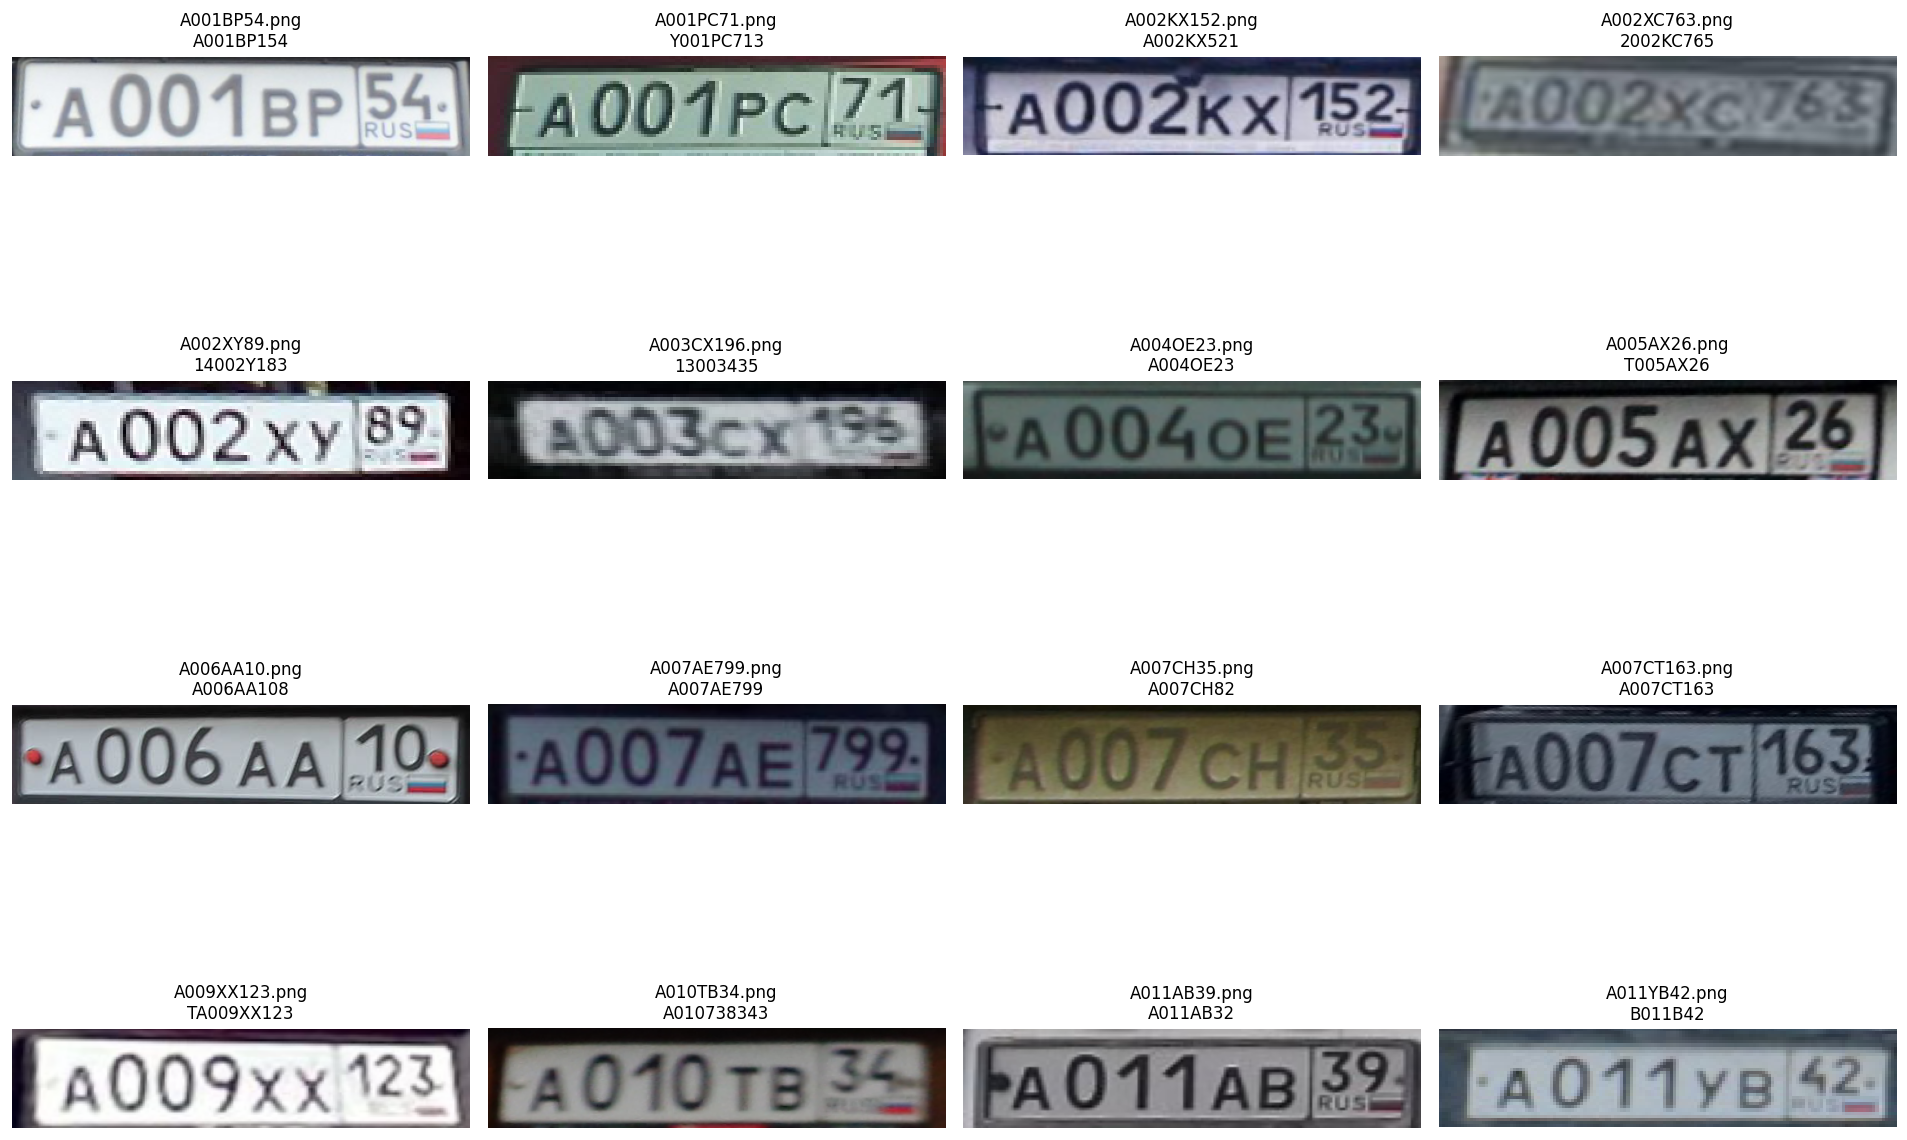

In [5]:
import os, glob, math, re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import cv2

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Папка с изображениями
IMG_DIR = <папка_с_изображениями>

# Лимит на количество обрабатываемых изображений (None — без ограничения)
MAX_IMAGES = 16

# Собираем изображения
EXTS = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff", "*.webp")
image_paths = []
for ext in EXTS:
    image_paths.extend(glob.glob(os.path.join(IMG_DIR, ext)))
image_paths = sorted(image_paths)

print(f"Найдено изображений: {len(image_paths)}")
if not image_paths:
    raise SystemExit("В папке нет изображений. Проверьте путь IMG_DIR.")

# Применяем ограничение
if MAX_IMAGES is not None and len(image_paths) > MAX_IMAGES:
    image_paths = image_paths[:MAX_IMAGES]
print(f"Будет обработано изображений: {len(image_paths)}")

# НОРМАЛИЗАЦИЯ И ШАБЛОН
latin_allowed = "ABEKMHOPCTYX"
cyr_to_lat_map = {
    "А":"A", "В":"B", "Е":"E", "К":"K", "М":"M", "Н":"H", "О":"O",
    "Р":"P", "С":"C", "Т":"T", "У":"Y", "Х":"X"
}
plate_regex = re.compile(r'^[ABEKMHOPCTYX]\d{3}[ABEKMHOPCTYX]{2}\d{2,3}$')

def normalize_plate(text: str) -> str:
    s = text.upper().replace(" ", "").replace("\n", "")
    out = []
    for ch in s:
        if ch in cyr_to_lat_map:
            ch = cyr_to_lat_map[ch]
        if ch.isdigit() or ch in latin_allowed:
            out.append(ch)
    return "".join(out)

def post_fix_by_pattern(s: str) -> str:
    # Поправка O↔0 и 8↔B по позициям формата A111AA77[7]
    if len(s) not in (8, 9):
        return s
    s = list(s)
    letter_pos = {0, 4, 5}
    digit_pos = set(range(len(s))) - letter_pos
    for i in range(len(s)):
        ch = s[i]
        if i in digit_pos:
            if ch == 'O': s[i] = '0'
            elif ch == 'B': s[i] = '8'
        else:
            if ch == '0': s[i] = 'O'
            elif ch == '8': s[i] = 'B'
    return "".join(s)

def score_candidate(s: str) -> tuple:
    match = bool(plate_regex.match(s))
    return (1 if match else 0, len(s))

# ПРЕПРОЦЕССИНГ
def pil_to_cv_gray(pil_img: Image.Image):
    rgb = np.array(pil_img.convert("RGB"))
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    return gray

def preprocess_variants(pil_img: Image.Image):
    gray = pil_to_cv_gray(pil_img)

    # Контраст (CLAHE) + шумоподавление + лёгкий unsharp
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g = clahe.apply(gray)
    g = cv2.bilateralFilter(g, 7, 50, 50)
    blurred = cv2.GaussianBlur(g, (0,0), 1.0)
    sharp = cv2.addWeighted(g, 1.5, blurred, -0.5, 0)

    # Масштабирование
    H, W = sharp.shape[:2]
    scale = 2.0 if max(W, H) < 350 else 1.3
    sharp_big = cv2.resize(sharp, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

    # Бинаризации
    th_otsu = cv2.threshold(sharp_big, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    th_adapt = cv2.adaptiveThreshold(
        sharp_big, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 10
    )

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    th_otsu = cv2.morphologyEx(th_otsu, cv2.MORPH_CLOSE, k, iterations=1)
    th_adapt = cv2.morphologyEx(th_adapt, cv2.MORPH_CLOSE, k, iterations=1)

    return [sharp_big, th_otsu, th_adapt]

# OCR
def ocr_plate(pil_img: Image.Image) -> str:
    whitelist = "ABEKMHOPCTYXАВЕКМНОРСТУХ0123456789"
    base_cfg = f'-l eng+rus --oem 1 -c tessedit_char_whitelist={whitelist} -c load_system_dawg=0 -c load_freq_dawg=0'

    variants = preprocess_variants(pil_img)
    candidates = []

    for img in variants:
        # Конвертация в PIL для pytesseract
        if isinstance(img, np.ndarray):
            pil = Image.fromarray(img).convert("L")
        else:
            pil = img

        for psm in (7, 8, 13):  # строка, слово, сырая строка
            cfg = f'{base_cfg} --psm {psm}'
            raw = pytesseract.image_to_string(pil, config=cfg)
            s = normalize_plate(raw)
            s = post_fix_by_pattern(s)
            if s:
                candidates.append(s)

    if not candidates:
        return ""

    candidates = sorted(set(candidates), key=score_candidate, reverse=True)
    return candidates[0]

# ОБРАБОТКА И ВИЗУАЛИЗАЦИЯ
results = []  # (path, PIL Image, text)
for path in image_paths:
    try:
        with Image.open(path) as im:
            im_rgb = im.convert("RGB")
            text = ocr_plate(im_rgb)
            results.append((path, im_rgb, text))
    except Exception as e:
        print(f"Ошибка при обработке {os.path.basename(path)}: {e}")
        results.append((path, None, ""))

# Рисуем сетку: картинка + распознанный текст в заголовке
n = len(results)
if n == 0:
    print("После ограничения нечего визуализировать.")
else:
    cols = min(4, n) if n > 0 else 1
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), dpi=120)
    ax_list = axes.ravel().tolist() if hasattr(axes, "ravel") else [axes]

    for i, (path, im_rgb, text) in enumerate(results):
        ax = ax_list[i]
        ax.axis("off")
        title_text = os.path.basename(path) + "\n" + (text if text else "—")
        if im_rgb is not None:
            ax.imshow(im_rgb)
        else:
            ax.text(0.5, 0.5, "Ошибка загрузки", ha="center", va="center")
        ax.set_title(title_text, fontsize=10)

    for j in range(n, len(ax_list)):
        ax_list[j].axis("off")

    plt.tight_layout()
    plt.show()